# Handling and Processing Time Series Data

## What is a "Time Series"

Timeseries data are samples observed in a chronological manner (across time). Some samples in different fields are:

    1) Economics - This field usually looks at timeseries indicators to know if a country is improving. Examples are :GDP,  Unemployment, Inflation, CPI, Poverty       
    2) Finance - Daytraders that focus on technical analysis are actually looking at timeseries data on stock prices
    3) Physics - Sin and cosine waves which are heavily used in understanding sound and spread of soundwaves across time.
    
    
    
## Why is it important to look at Time series data?

    1) Understand the process behind a specific indicator
    2) Create simulations to understand what might happen in the future & eventually put controls in order to avoid/surpass forecasts
    3) To know what factors affect the series being analyzed / is there another series that affect the fluctuations of another? (e.g. Demand for Ice cream vs Temperature)
    
    
## Some Samples

`DJIA 30 Stock Time Series` - Average stock price of specific companies included in the Dow Jones Index (used to assess market health).

![Stocks](https://miro.medium.com/max/1400/0*bCS3EWiVfLIZqwIW.gif)

`Voice sampled every .2 seconds` - Average frequency and amplitude of voice sampled at specific timeframes. Time series representation of voices are actually used to model voice recognition algorithms.


![Voice](https://miro.medium.com/max/700/1*80fnKgU_07EzqXWkJXZrQQ.png)

`Inflation Across Time Among the ASEAN Countries` - This shows the trend of inflation of different countries across time. Kinda shows how bad it is here in the PH as compared to other countries
![Inflation](https://assets.rappler.co/4A0970D12C774D96850FBCDB5D2707AA/img/86CDAB18C8304B6CB5DACBF8CA471CBC/Fig_1_aseaninf.png)




## Difference in handling Time Series Data

Given the difference in the behavior of time series data with panel data (samples differ per row), there are different preprocessing techniques applied to be able to clean your dataset.

Lets discuss the usual preprocessing techniques applied to time series data and how it differs with panel data. But before that, we will first discuss the dataset that we'll be using today. We will use stocks data from yfinance. Luckily theres a free python library that will allow us to pull data easily.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
stock_name = 'MSFT'
start_date="2019-01-01"
end_date="2022-01-01"

# Valid Intervals : 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
interval_val = '1D'

data = yf.download(stock_name, start=start_date, end=end_date, interval = interval_val)
data.head()

data = data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [3]:
# data.to_excel('Data For Students.xlsx', index=False)

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-31,101.290001,102.400002,100.440002,101.570000,97.787132,33173800
1,2019-01-02,99.550003,101.750000,98.940002,101.120003,97.353905,35329300
2,2019-01-03,100.099998,100.190002,97.199997,97.400002,93.772461,42579100
3,2019-01-04,99.720001,102.510002,98.930000,101.930000,98.133743,44060600
4,2019-01-07,101.639999,103.269997,100.980003,102.059998,98.258904,35656100


### Data Dictionary



| Variable  | Definition                               | Key                                            |
| --------- | ---------------------------------------- | ---------------------------------------------- |
| Date  | Timeperiod Covered (Depends on Interval Selected)                                 | Can be days, minutes, hours                                |
| Open    | Opening Stock Price (SP)                             | Stock Price                      |
| High       | Highest SP within the period selected                                      |      Stock Price                                          |
| Low       | Lowest SP within the period selected                             |       Stock Price                                         |
| Close     |Closing SP within the period selected |   Stock Price                                             |
| Adj Close     | Closing SP with adjustments |                                          Stock Price      |
| Volume    | Total Stocks issued                          |                     Quantity                           |


### Exploratory Data Analysis

#### How Big is our Data?

We have a total of 7 columns and 506 day sample

In [5]:
data.shape

(758, 7)

#### Data Type and Nulls

Make sure that the columns have the proper datatypes, specially the date columns. We can see from the results below that each columns have the correct datatype.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       758 non-null    datetime64[ns]
 1   Open       758 non-null    float64       
 2   High       758 non-null    float64       
 3   Low        758 non-null    float64       
 4   Close      758 non-null    float64       
 5   Adj Close  758 non-null    float64       
 6   Volume     758 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 41.6 KB


In case the datatype of the datecolumn is not correct, we can convert it to datetime by using the code below. Note that format can be explicitly stated but if that parameter is set to None, pandas will automatically detect what the format of the column is. Check out the documentation for more info : 

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

### Feature Engineering

From the previous discussions before, we know that we can extract multiple features from dates. Lets try to get the following from our data:

    Year
    Day
    Weekday Index
    Weekday Name
    Is Weekend / Weekday

In [8]:
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
data['Weekday Index'] = data['Date'].dt.weekday
data['Weekday Name'] = data['Date'].dt.day_name()
data['IsWeekday'] = ['Weekend' if i > 4 else 'Weekday' for i in data['Weekday Index']]

### Is there anything weird with the data?

Looking at maximum weekday index, it seems that we dont have stock prices data with weekday index 5 and 6, this implies we dont have values for Saturdays and Sundays. Lets try to confirm this by getting the frequency of samples across weekday index


In [9]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Year,Day,Weekday Index
count,758.000000,758.000000,758.000000,758.000000,758.000000,7.580000e+02,758.000000,758.000000,758.000000
mean,199.500396,201.432480,197.568760,199.644485,196.510095,2.943369e+07,2019.997361,15.749340,2.011873
std,65.235627,65.709074,64.783083,65.301199,65.997260,1.307388e+07,0.819184,8.784547,1.400553
min,99.550003,100.190002,97.199997,97.400002,93.772461,8.989200e+06,2018.000000,1.000000,0.000000
25%,139.477501,140.365002,137.902496,139.037498,135.222797,2.145940e+07,2019.000000,8.000000,1.000000
50%,200.235001,203.799995,197.625000,201.605003,198.054436,2.599730e+07,2020.000000,16.000000,2.000000
75%,243.884995,245.525005,241.967495,243.784996,241.231487,3.332410e+07,2021.000000,23.000000,3.000000
max,344.619995,349.670013,342.200012,343.109985,341.606354,9.701270e+07,2021.000000,31.000000,4.000000


It seems that we dont have stock prices reported during the weekend. And this is expected because stock markets are **closed during the weekends!**



In [10]:
data['Weekday Index'].value_counts().reset_index().sort_values(by='index', ascending=True)

,index,Weekday Index
4,0,144
0,1,156
1,2,155
2,3,153
3,4,150


In [11]:
data['Weekday Name'].value_counts().sort_values()

Monday       144
Friday       150
Thursday     153
Wednesday    155
Tuesday      156
Name: Weekday Name, dtype: int64

In [12]:
data['IsWeekday'].value_counts().sort_values()

Weekday    758
Name: IsWeekday, dtype: int64

### Imputation

One big difference between timeseries data and panel data is timeseries are frequently analyzed continuously as time progress (hence the series in the name). There are times that we'd need to show all values, EVEN IF IT's zero. In this case, lets say that we'd want to show weekend values as 0 to indicate that there is no trading activity during that day. We can do it by using the code below : 

In [13]:
sample_imputation = data.copy()

In [14]:
sample_imputation.index = sample_imputation['Date']

In [15]:
## Code Provided by Nidhi Sharma
## https://stackoverflow.com/questions/47231496/pandas-fill-missing-dates-in-time-series

def fill_in_missing_dates(df,
                          date_col_name = 'date',
                          fill_val =np.nan,
                          date_format='%Y-%m-%d'):
    
    df.set_index(date_col_name,drop=True,inplace=True)
    
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(df.index.min(), df.index.max())
    print('missing_dates are',idx.difference(df.index))
    df=df.reindex(idx,fill_value=fill_val)
    
    return df


In [16]:
sample_imputation = fill_in_missing_dates(sample_imputation,
                                          date_col_name = 'Date',
                                          fill_val = 0,
                                          date_format='%Y-%m-%d')
# -> we fill it with 0, and not NaN

missing_dates are DatetimeIndex(['2019-01-01', '2019-01-05', '2019-01-06', '2019-01-12',
               '2019-01-13', '2019-01-19', '2019-01-20', '2019-01-21',
               '2019-01-26', '2019-01-27',
               ...
               '2021-11-28', '2021-12-04', '2021-12-05', '2021-12-11',
               '2021-12-12', '2021-12-18', '2021-12-19', '2021-12-24',
               '2021-12-25', '2021-12-26'],
              dtype='datetime64[ns]', length=339, freq=None)


In [17]:
sample_imputation.shape
# -> We now have 1097 rows, as we have added the rows for the weekends

(1097, 11)

### Getting the features for the imputed values

Here we try to extract features from the date again (since new datapoints were added)

In [18]:
sample_imputation.head()
# -> As we can see, the day and weekday index should not be 0, so we have to
# compute it using the date. However, we don't have a date column, which
# is why we're going to create one using the index.

,Open,High,Low,Close,Adj Close,Volume,Year,Day,Weekday Index,Weekday Name,IsWeekday
2018-12-31,101.290001,102.400002,100.440002,101.570000,97.787132,33173800,2018,31,0,Monday,Weekday
2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0
2019-01-02,99.550003,101.750000,98.940002,101.120003,97.353905,35329300,2019,2,2,Wednesday,Weekday
2019-01-03,100.099998,100.190002,97.199997,97.400002,93.772461,42579100,2019,3,3,Thursday,Weekday
2019-01-04,99.720001,102.510002,98.930000,101.930000,98.133743,44060600,2019,4,4,Friday,Weekday


In [19]:
sample_imputation['Date'] = sample_imputation.index

In [20]:
sample_imputation['Year'] = sample_imputation['Date'].dt.year
sample_imputation['Day'] = sample_imputation['Date'].dt.day
sample_imputation['Weekday Index'] = sample_imputation['Date'].dt.weekday
sample_imputation['Weekday Name'] = sample_imputation['Date'].dt.day_name()
sample_imputation['IsWeekday'] = ['Weekend' if i > 4 else 'Weekday' for i in sample_imputation['Weekday Index']]

In [21]:
sample_imputation['Weekday Name'].value_counts().sort_values()
# -> As we can see, there are also missing weekdays which are for the holidays.

Saturday     156
Sunday       156
Friday       157
Wednesday    157
Tuesday      157
Thursday     157
Monday       157
Name: Weekday Name, dtype: int64

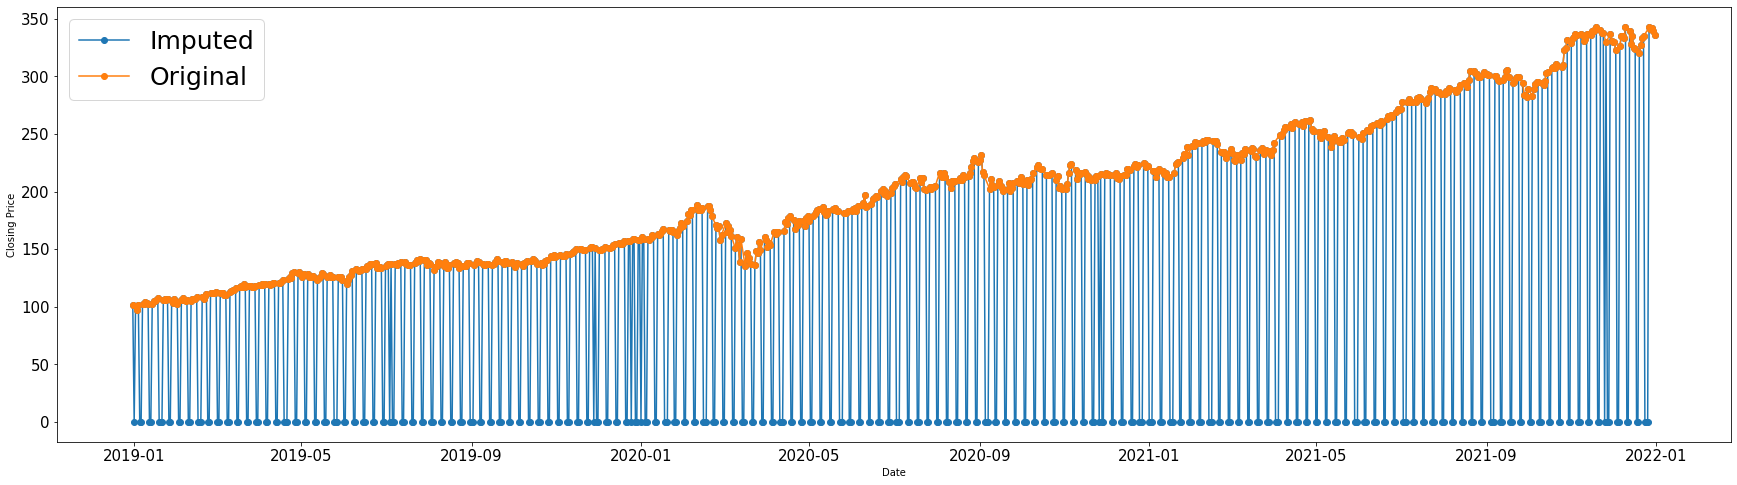

In [22]:
plt.figure(figsize=(30,8))

# Plotting the Imputed Data (blue)
plt.plot(sample_imputation['Date'], sample_imputation['Close'], marker='o', label='Imputed')

#Plotting the original data (orange)
plt.plot(data['Date'], data['Close'], marker='o', label='Original')

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

# -> The imputed data are the ones that drop to 0.
# -> If we put null for the imputed values, we would see gaps, instead
# of the sudden drops to 0. So, there would be no connecting lines.

In [23]:
# What if we want to impute using the mean value of the closing stock price?
# -> This is because the previous days value has an affect on today's
# value. This is the auto-correlation that comes with everything 
# related to time. Instead of dropping down to 0, it would be a straightline
# to the next value. It depends on the analysis that you need to do.

## Aggregation and Granularity

Granularity in panel data talks about the level of grouping of the samples. Usually we group them to be able to analyze samples a larger scale. Similarly, we can also group time series data depending on the level of **temporality** that you would want to check. The usual level of grouping for time is : 

`Seconds` -> `Minutes` -> `Hours` -> `Days` -> `Weeks` -> `Months` -> `Years` -> `Decades` -> `Centuries`

(Usually, we end our analysis with years. But, if the thing that we're going to analyze is a long period of time, we analyze it by decade.)

Example : 


![Stocks](http://kourentzes.com/forecasting/wp-content/uploads/2014/05/fors1.fig1_.png)



Implementing this using pandas is quite straightforward, similar to panel data, we will use the **groupby** function to group the timeseries data together and we will have to specify the following:

    Groups Involved - what are the columns that we'll include to the aggregation (i.e. per stock, per week)
    Granularity - what level of grouping do we need? How high or how low? 
    Type of Aggregation - how do we group the values together (mean / sum)

In [24]:
weekly_aggregate = data.groupby(pd.Grouper(key='Date', freq='W'))['Close'].mean().reset_index()
month_aggregate = data.groupby(pd.Grouper(key='Date', freq='MS'))['Close'].mean().reset_index()
month_aggregate_ = data.groupby(pd.Grouper(key='Date', freq='M'))['Close'].mean().reset_index()
# -> The month aggregator aggregates by the end of the month. If we want it to be 
# aggregated by the start of the month, we should use MS.

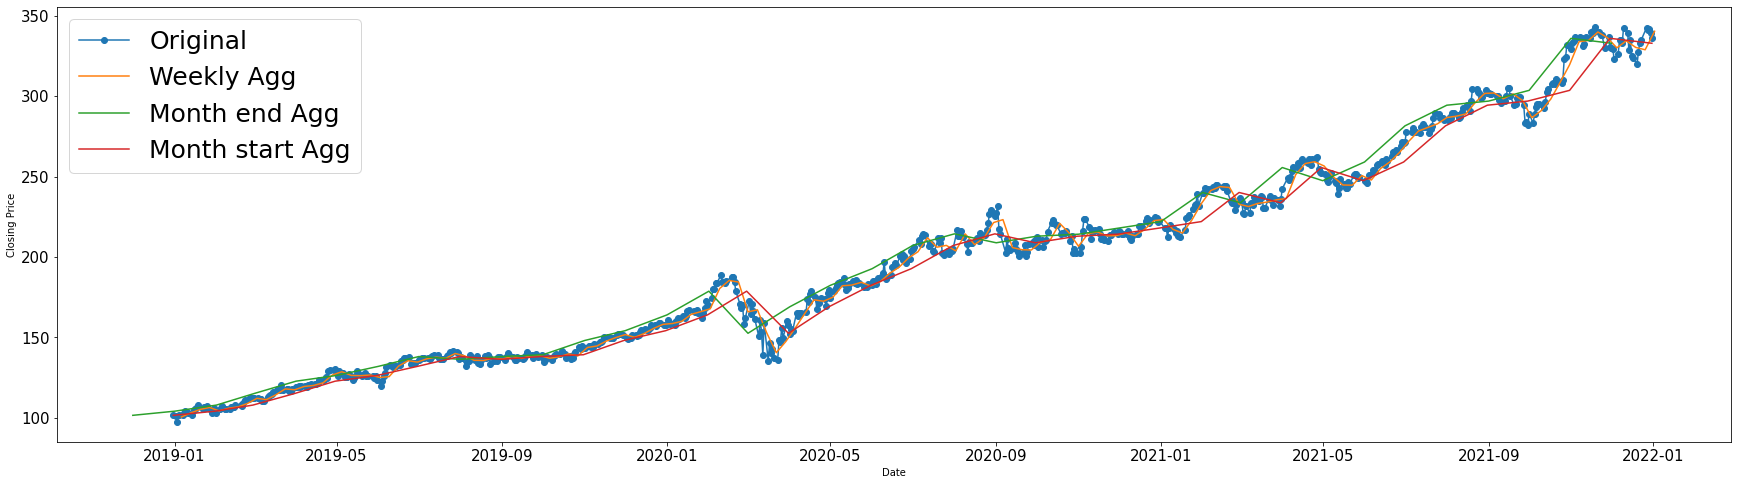

In [25]:
plt.figure(figsize=(30,8))

#Plotting the original data (orange)
plt.plot(data['Date'], data['Close'], marker='o', label='Original')

#Plotting the Grouped Data with different Granularity
plt.plot(weekly_aggregate['Date'], weekly_aggregate['Close'], label='Weekly Agg')
plt.plot(month_aggregate['Date'], month_aggregate['Close'], label='Month end Agg')
plt.plot(month_aggregate_['Date'], month_aggregate_['Close'], label = 'Month start Agg')

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

# -> In time series, we usually aggregate by sum and mean.
# -> We get the sum if we want to get the total of the data.
# -> Usually, getting the average of the revenue, money, etc.,
# is not logical. 
# -> In analyzing stocks, we usually do not get the sum because
# it does not compound. This is why we aggregate by the mean.
# -> We would see that the aggregator would smooth out the line. 
# -> In the weekly aggregate, we can see that there is still noise
# as there are still up and downs. If we aggregate higher,
# we would see that there are only small shifts.
# -> However, this type of aggregate is not what we usually use
# for time series data. Because if we just get the average
# per month, the calculation would not factor in the previous
# months, which means that it does not factor in the auto-correlation
# (the past is somehow related to the present value) that is 
# inherent to time-series data.

## Aggregation via a Moving Window

Notice that as we increase the granularity of the grouping, we were able to "smoothen" the graph. This is because time series aggregation will account for the the variation observed in the granular data (similar to when we group samples to specific categories to get descriptive statistics). 

One flaw in the usual aggregation method is it only accounts for the data at the specific window that we are aggregating (i.e. if we aggregate by month, the calculation will not factor in the previous months). It is in the nature of timeseries that datapoints are **autocorrelated** meaning the past is somehow related with the present values. This means that whatever the past values are in the series, it may have meaningful relationship with the present values that we **SHOULD** account for. Moving or Rolling averages were created to be able to account for this "flaw" in the usual timeseries aggregation method. Mathematically, moving averages are calculated using this formula :

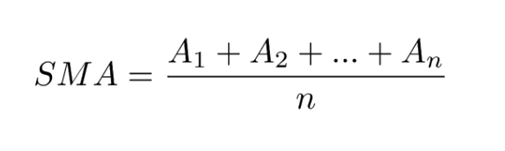

Procedurally, this is what happens under the hood : 

![Moving average info](https://media.geeksforgeeks.org/wp-content/uploads/20211116101813/Capture.PNG)

We can implement it in python using the code block below : 

In [26]:
data['7day MA'] = data['Close'].rolling(window =7).mean()
# -> the window depends on the granularity of the data.

In [27]:
data.head(10)
# -> We can see that the value for the 7day MA starts at the 
# 7th row because we need 7 data points (we don't have at least
# 7 previous values in the first 6 rows).

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Day,Weekday Index,Weekday Name,IsWeekday,7day MA
0,2018-12-31,101.290001,102.400002,100.440002,101.570000,97.787132,33173800,2018,31,0,Monday,Weekday,NaN
1,2019-01-02,99.550003,101.750000,98.940002,101.120003,97.353905,35329300,2019,2,2,Wednesday,Weekday,NaN
2,2019-01-03,100.099998,100.190002,97.199997,97.400002,93.772461,42579100,2019,3,3,Thursday,Weekday,NaN
3,2019-01-04,99.720001,102.510002,98.930000,101.930000,98.133743,44060600,2019,4,4,Friday,Weekday,NaN
4,2019-01-07,101.639999,103.269997,100.980003,102.059998,98.258904,35656100,2019,7,0,Monday,Weekday,NaN
5,2019-01-08,103.040001,103.970001,101.709999,102.800003,98.971352,31514400,2019,8,1,Tuesday,Weekday,NaN
6,2019-01-09,103.860001,104.879997,103.239998,104.269997,100.386589,32280800,2019,9,2,Wednesday,Weekday,101.592857
7,2019-01-10,103.220001,103.750000,102.379997,103.599998,99.741531,30067600,2019,10,3,Thursday,Weekday,101.882857
8,2019-01-11,103.190002,103.440002,101.639999,102.800003,98.971352,28314200,2019,11,4,Friday,Weekday,102.122857
9,2019-01-14,101.900002,102.870003,101.260002,102.050003,98.249283,28437100,2019,14,0,Monday,Weekday,102.787143


### Pros and Cons of using MA

Pros :
    
    Information from the Past - this method accounts for the possible relationship of past values with the present

    Smoothness - allows for the series to be smoothened making trend more visible (higher window, the smoother the series will be)

    Can be used for forecast - one of the most intuitive and classical model
    
Cons :
    
    Loss of data

In [28]:
data ['7day SD'] = data ['Close'].rolling(window = 7).std()
data.head(10)

# -> The standard deviation shows us the intensity of the change
# or the variability of the data in those seven days (i.e., 
# how drastic the changes are). 

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Day,Weekday Index,Weekday Name,IsWeekday,7day MA,7day SD
0,2018-12-31,101.290001,102.400002,100.440002,101.570000,97.787132,33173800,2018,31,0,Monday,Weekday,NaN,NaN
1,2019-01-02,99.550003,101.750000,98.940002,101.120003,97.353905,35329300,2019,2,2,Wednesday,Weekday,NaN,NaN
2,2019-01-03,100.099998,100.190002,97.199997,97.400002,93.772461,42579100,2019,3,3,Thursday,Weekday,NaN,NaN
3,2019-01-04,99.720001,102.510002,98.930000,101.930000,98.133743,44060600,2019,4,4,Friday,Weekday,NaN,NaN
4,2019-01-07,101.639999,103.269997,100.980003,102.059998,98.258904,35656100,2019,7,0,Monday,Weekday,NaN,NaN
5,2019-01-08,103.040001,103.970001,101.709999,102.800003,98.971352,31514400,2019,8,1,Tuesday,Weekday,NaN,NaN
6,2019-01-09,103.860001,104.879997,103.239998,104.269997,100.386589,32280800,2019,9,2,Wednesday,Weekday,101.592857,2.111884
7,2019-01-10,103.220001,103.750000,102.379997,103.599998,99.741531,30067600,2019,10,3,Thursday,Weekday,101.882857,2.243498
8,2019-01-11,103.190002,103.440002,101.639999,102.800003,98.971352,28314200,2019,11,4,Friday,Weekday,102.122857,2.238144
9,2019-01-14,101.900002,102.870003,101.260002,102.050003,98.249283,28437100,2019,14,0,Monday,Weekday,102.787143,0.881923


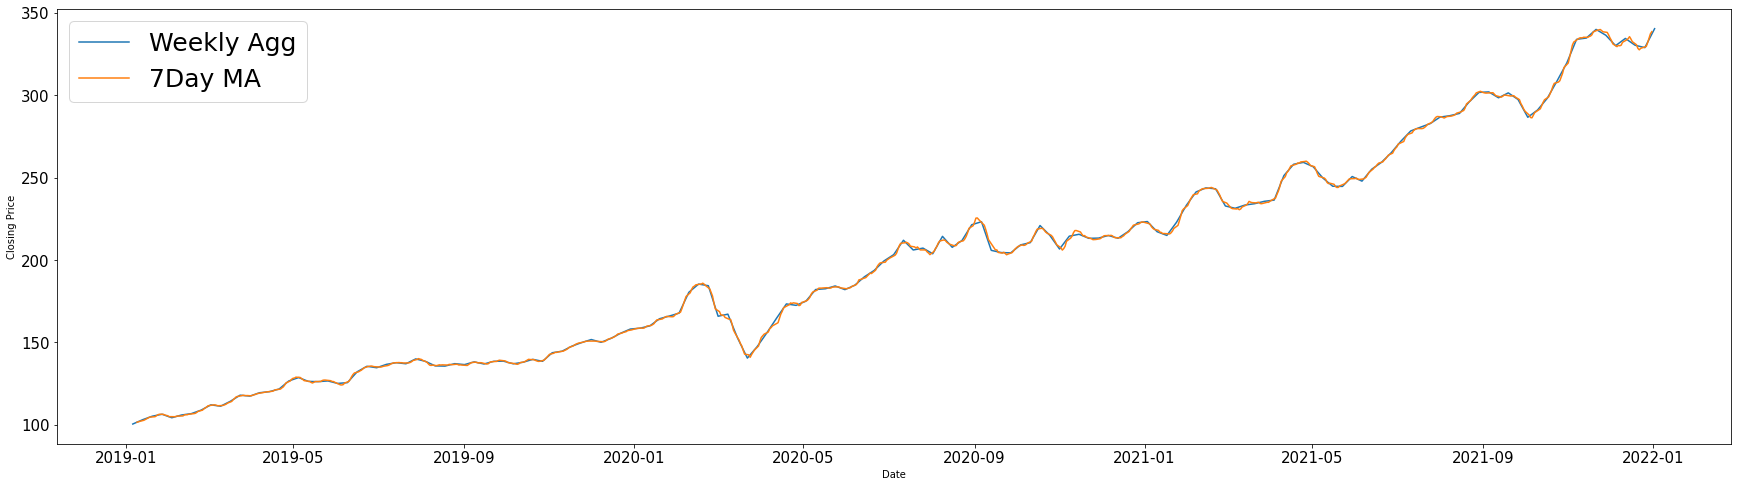

In [29]:
# Smoothness
plt.figure(figsize=(30,8))

#Plotting the original data (orange)
# plt.plot(data['Date'], data['Close'], marker='o', label='Original')

plt.plot(weekly_aggregate['Date'], weekly_aggregate['Close'], label='Weekly Agg')

#Plotting the 7Day MA
plt.plot(data['Date'], data['7day MA'], label='7Day MA')

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

# -> The blue line (weekly agg) is sharper in most cases.
# -> The moving average is a little more accurate on 
# representing the data.
# -> Notice, at the beginning, there is a blue line with no 
# corresponding orange line, which is the first six days.

In [30]:
# Loss of Data
data[['Date','Close', '7day MA']]

,Date,Close,7day MA
0,2018-12-31,101.570000,NaN
1,2019-01-02,101.120003,NaN
2,2019-01-03,97.400002,NaN
3,2019-01-04,101.930000,NaN
4,2019-01-07,102.059998,NaN
...,...,...,...
753,2021-12-27,342.450012,329.462860
754,2021-12-28,341.250000,331.798575
755,2021-12-29,341.950012,334.391436
756,2021-12-30,339.320007,337.164294


## Detection of Outliers


`Zscore` - similar to panel data, you can use zscores to spot outliers within the dataset. In fact, this is the most basic anomaly detection algorithm used for time series. You can easily spot weird behavior across time by simply getting the zscore values and plotting it against the series.

In [31]:
"""
In time series data, outliers are considered to be events. Whenever
we have a spike in the dataset (i.e., if it's not the usual trend
or it's not within the standard deviation), that's usually an event
or an anomaly that happened that's why there's suddenly a big change
in the data.

We can use z-scores to spot outliers. This is basically just getting
the mean, and getting the mean and then getting how many standard
deviations away are you from the mean in terms of your dataset.
"""

"\nIn time series data, outliers are considered to be events. Whenever\nwe have a spike in the dataset (i.e., if it's not the usual trend\nor it's not within the standard deviation), that's usually an event\nor an anomaly that happened that's why there's suddenly a big change\nin the data.\n\nWe can use z-scores to spot outliers. This is basically just getting\nthe mean, and getting the mean and then getting how many standard\ndeviations away are you from the mean in terms of your dataset.\n"

In [32]:
# Subsampling the datapoints only to include 2020 stock prices of microsoft
# Increasing granularity to weeks

# -> We are only focusing on this range because based on the graph 
# above regarding the MA, we can see that there's a dip in the data
# between this range.
# -> Anomaly detection is usualyl only done between month or a year.
# This depends on the granularity again.
outlier_sample = data[(data['Date'].dt.year == 2020) & (data['Date'].dt.month <= 5)]

outlier_sample = outlier_sample.groupby(pd.Grouper(key='Date', freq='D'))['Close'].mean().reset_index()
outlier_sample = outlier_sample.dropna()

In [33]:
outlier_sample.head()

,Date,Close
0,2020-01-02,160.619995
1,2020-01-03,158.619995
4,2020-01-06,159.029999
5,2020-01-07,157.580002
6,2020-01-08,160.089996


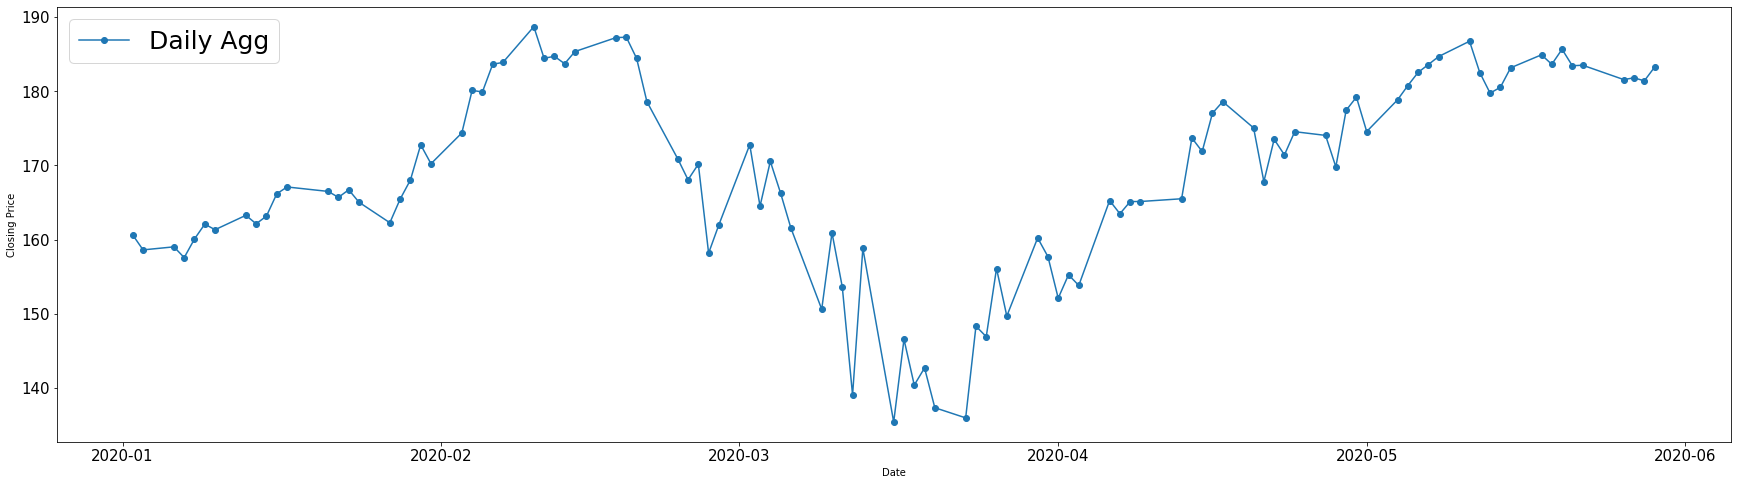

In [34]:
# Subsampled data
plt.figure(figsize=(30,8))

plt.plot(outlier_sample['Date'], outlier_sample['Close'], label='Daily Agg', marker='o')

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

In [35]:
outlier_sample['zscore'] = stats.zscore(outlier_sample['Close'])

Here we will establish a certain threshold before we flag a datapoint as an outlier. Similar with panel data, we need to know how many standard deviations away from the mean will we consider as normal vs as anomalous. As an example, lets say we will deem datapoints that is +/- 1 standard deviation away from the mean as anomalous

In [36]:
mean_value = outlier_sample['zscore'].mean()
print(mean_value)
standard_dev_val = 1

# -> Then we will get the average of the zscore so that we can 
# see how many SD away should we get from the dataset.
# -> The z-score is just like sub-sampling or factoring your data
# to fit within a certain range of data.

2.8240624509882625e-16


Plotting the threshold band will allow us to easily spot the trends present in our dataset. Looking at the firs quarter of 2020, there seems to be an event that decreased the price of microsoft for `multiple weeks`. In time series analysis, these trends are usually points of reflection and we try to make sense of the trend by looking at factors that might have caused such behavior.

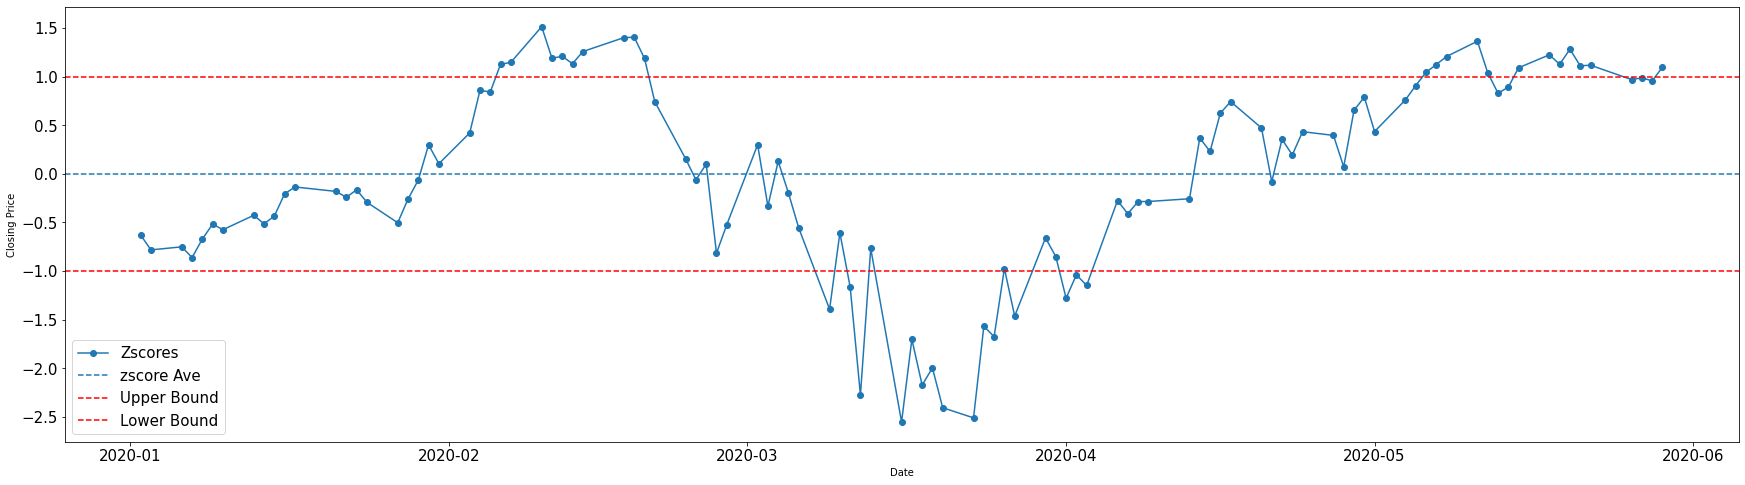

In [37]:
# Plotting Zscores across time
plt.figure(figsize=(30,8))

plt.plot(outlier_sample['Date'], outlier_sample['zscore'], label='Zscores', marker='o')

plt.axhline(outlier_sample['zscore'].mean(), label='zscore Ave', linestyle='--')


plt.axhline(standard_dev_val, label='Upper Bound', linestyle='--', color='red')

plt.axhline(-standard_dev_val, label='Lower Bound', linestyle='--', color='red')

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

# -> Everything within the red lines are regular/normal data.
# -> We can set our own threshold. We can also set it to be 
# 2 standard deviation away, so that the only events that we 
# would find are the those that are so extreme. We would also 
# take note of these points as the extreme datapoints.

In [38]:
# -> We can also try to do it this way.
outlier_sample.Close.mean()

168.8594172209212

In [39]:
outlier_sample.Close.std()

13.158568267304686

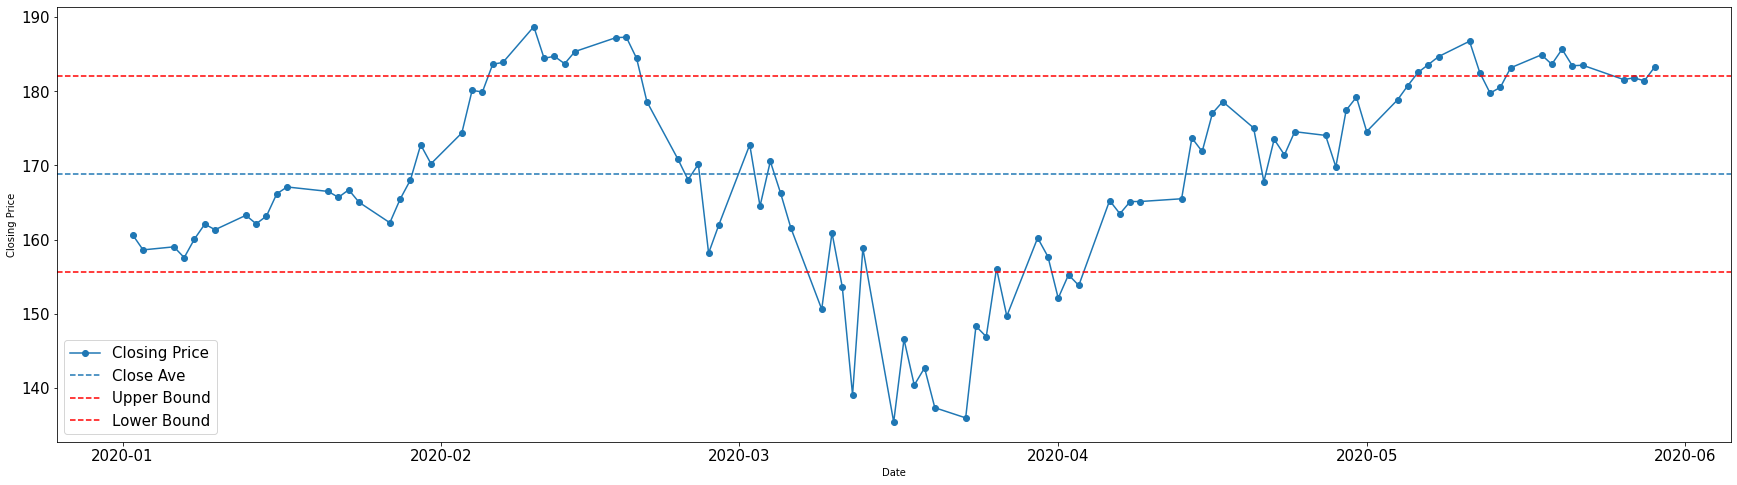

In [40]:
plt.figure(figsize=(30,8))

plt.plot(outlier_sample['Date'], outlier_sample['Close'], label='Closing Price', marker='o')

plt.axhline(outlier_sample['Close'].mean(), label='Close Ave', linestyle='--')


plt.axhline(outlier_sample['Close'].mean() + outlier_sample.Close.std(), label='Upper Bound', linestyle='--', color='red')

plt.axhline(outlier_sample['Close'].mean() - outlier_sample.Close.std(), label='Lower Bound', linestyle='--', color='red')

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

# -> As we can see, it is the same graph. We can also have a 
# multiplier for the standard deviation to widen the range.
# outlier_sample['Close'].mean() - (2 *  outlier_sample.Close.std())
# -> The z-score just changes the data to follow a normal 
# distribution so that it is balanced.
# -> NOTE: This allows us to find the dates that are out of the
# ordinary, wherein it drops significantly. Then, we can analyze
# these dates: what happened during these dates, and what factors
# that might have contributed to price drops.

## Major Components of Observed Time Series

Time series have components that we can look at to further understand the behavior of our data.

`Trend` - long term slope and direction of the timeseries. Question : How long is long? and what if there are shifts in trend?

`Cycle` - pattern in data that is observed but is not chunked within a specific timeframe (i.e. repeat during x number of weeks/days, but boom and bust is observable)

`Seasonality` - calendar based effects (seasons, definite scheduled holidays, tax periods)


`Irregularity` - term to capture stochasticity and randomness.


### Extracting the Major Components of a Series

Decomposition is a technique that can help us make sense of a time series. The result of decomposition will allow us to know what kind of "preprocessing" technique to apply to the series before we can move forward with more complex analysis and modelling.

The two most common ways to decompose a series are : 

    Additive Model - states that the series can be created by aggregating the estimated componantes together

    Multiplicative Model - states that the series can be created by multiplying the estimated componantes together

The code below will allow us to extract the important components of a timeseries

In [ ]:
# -> This is usually done before analysis, but after data preperation.
# -> This is usually done for analysis.

decompose_sample = data.copy()

decompose_sample = decompose_sample.groupby(pd.Grouper(key='Date', freq='MS'))['Close'].mean().reset_index()

decompose_sample = decompose_sample.set_index(pd.to_datetime(decompose_sample['Date'])).dropna()

decompose_sample.sort_index(inplace=True)

In [ ]:
decompose_sample['Year'] = decompose_sample['Date'].dt.year
decompose_sample['Month'] = decompose_sample['Date'].dt.month

In [ ]:
# Analyze first the original series 
# What is the trend? What months, on average is high?
# What to expect when we extract the components?
plt.figure(figsize=(15, 5))
for each in decompose_sample['Year'].unique():
    plt.plot(decompose_sample[decompose_sample['Year'] == each]['Month'],
             decompose_sample[decompose_sample['Year'] == each]['Close'], marker='o', label=each)
    
    plt.legend()
    plt.xlabel('Months')
    plt.ylabel('Monthly Closing Ave')
    plt.title('Monthly Closing Ave Across Months')

In [ ]:
result = seasonal_decompose(decompose_sample['Close'], model='additive')

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(result.observed)
plt.title("Observed")
plt.figure(figsize=(10,3))
plt.plot(result.trend)
plt.title("Trend")
plt.figure(figsize=(10,3))
plt.plot(result.seasonal)
plt.title("Seasonal")
plt.figure(figsize=(10,3))
plt.plot(result.resid)
plt.title("Residuals")

### Monthly expectation

By analyzing the seasonality index extracted, we can somehow see the effect of certain months on the closing stock price. The graph below will give us an idea if a certain month has a positive / negative effect on the average closing price for that specific month.

In [ ]:
seasonality_value = result.seasonal.reset_index()

seasonality_value['Month'] = seasonality_value['Date'].dt.month
seasonality_value = seasonality_value[['seasonal', 'Month']].drop_duplicates()

Here we can see that Microsoft's stock prices drop (on average) during January, March, April, May, October, November and December.

In [ ]:
plt.figure(figsize=(20,3))

plt.bar(seasonality_value[seasonality_value['seasonal'] > 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] > 0]['seasonal'])


plt.bar(seasonality_value[seasonality_value['seasonal'] <= 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] <= 0]['seasonal'])

## Preprocessing Techniques Depend on Seasonality and Trend

The result that we get from decomposition will dictate what kind of preprocessing technique should be applied to the data. If you find that the data has seasonality / trend, we can use the table below to know how to impute for missing values. 

| Season      | Trend |Trendless |
| ----------- | ----------- |----------- |
| Seasonal      |Use __MEAN__ of the __adjacent__ years (same period)|Use __MEAN__ of __all__ available data |
| Non-Seasonal   |Use __MEAN__ of the __adjacent__ datapoints|Use __MEAN__ of __all__ available data  |


By following this table, we can more or less generate more accurate models.


## Stationarity and Autocorrelation


Some algorithms require stationarity of a series before it can be modelled. Non-stationary data, when used to train classical models (i.e. ARIMA) will result to autocorrelated residuals implying that the errors are severly increasing across time. This just means that the past values are dependent or **CORRELATED** with present and future values.  Residuals (Prediction - Actuals) that are not serially correlated is an assumption that must be passed before we can interpret ARIMA and other classical models. There are different preprocessing techniques that you can use to remove this relationship from the series.

A series that is stationary is defined to have the following properties :

    1) Trendless
    2) No predifined seasonality
    
    
![Stationarity](https://0megap0int.files.wordpress.com/2021/07/stationary.png)
    
    

### Differencing

You can difference the input series to be able to remedy for non-stationarity. Differencing is the direct subtraction of adjacent datapoints of timeperiod selected.





In [ ]:
data['Differenced First Order'] = data['Close'].diff()

In [ ]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(data['Date'], data['Close'], label='Actual Series', marker='o')
plt.plot(data['Date'], data['Differenced First Order'], label='Differenced Series', marker='o')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

The formal way to check for stationarity is by using the Augmented Dickey-Fuller test where the null hypothesis is :

Null = Series is NON-STATIONARY

Alternative = Series is STATIONARY

In [ ]:
result = adfuller(data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
result = adfuller(data['Differenced First Order'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Log transform

Another technique to tame non-stationarity is by getting the logarithmic transform of the series

In [ ]:
data['Log Close'] = np.log(data['Close'])

In [ ]:
# Plotting Data
plt.figure(figsize=(30,8))

# plt.plot(data['Date'], data['Close'], label='Actual Series', marker='o')
plt.plot(data['Date'], data['Log Close'], label='Log Series', marker='o')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Closing Price');

In [ ]:
result = adfuller(data['Log Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))